In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Net_Visualizer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME

!git config --global user.email 'arjun2000ashok@gmail.com'
!git config --global user.name 'Arjun Ashok'

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Net_Visualizer


# Git

In [ ]:
!git add .
!git commit -m 'Moved all to files,to be checked'
!git push -u origin master

[master 02c0c0c] Moved all to files,to be checked
 4 files changed, 180 insertions(+), 39 deletions(-)
 rewrite adversarial_fooling.py (61%)
 rewrite class_visualization.py (64%)
 rewrite visualizer.ipynb (70%)
Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 764.91 KiB | 4.69 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/aiarjun/Network-Visualizer.git
   e93ded5..02c0c0c  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


# Code testing

## Saliency map

A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. 

To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (3, H, W) then this gradient will also have shape (3, H, W); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. 


To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.

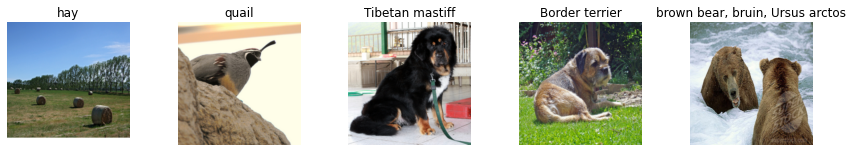

In [ ]:
from utils import *
X, y, idx2label = load_imagenet_val(count=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(idx2label[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [ ]:
model = get_pretrained_squeezenet()
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)

model.eval()
X_tensor.requires_grad_()

scores = model(X_tensor)
correct_label_scores = (scores.gather(1, y_tensor.view(-1, 1)).squeeze())
correct_label_scores.backward(torch.FloatTensor([1.0]*correct_label_scores.shape[0]))

saliency, _ = torch.max(X_tensor.grad.data.abs(), axis = 1)

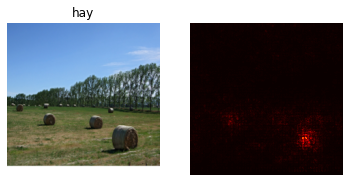

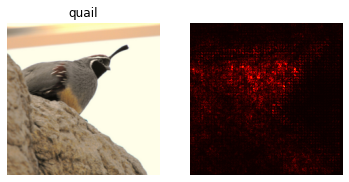

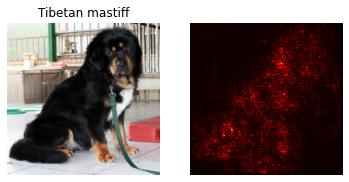

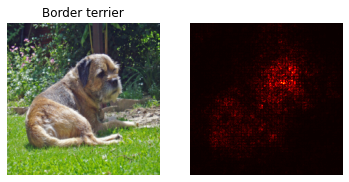

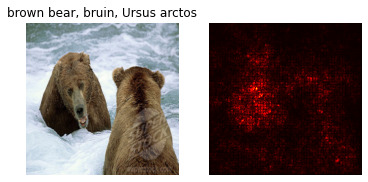

In [ ]:
saliency = saliency.numpy()
N = X.shape[0]
figures = []
for i in range(N):
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(X[i])
    ax.axis('off')
    ax.set_title(idx2label[y[i]])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(saliency[i], cmap=plt.cm.hot)
    ax.axis('off')
    figures.append(fig) 

# plt.show()

In [ ]:
figures

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

## Adversarial Fooling

We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient ascent over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [ ]:
def make_fooling_image(X, target_y, model):
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    learning_rate = 1
    iter = 0
    print_every = 10

    while True:
        scores = model(X_fooling)
        _, idx = torch.max(scores, 1)
        if (idx != target_y):
            scores[:,target_y].backward()
            dX = learning_rate*X_fooling.grad.data/torch.norm(X_fooling.grad.data)
            X_fooling.data += dX.data
            X_fooling.grad.data.zero_()
            if iter % print_every == 0:         
              print('Iteration %d, target indices\' scores: ' % (iter), scores[:,target_y].data)
            iter += 1
        else:
            break 
    return X_fooling

In [ ]:
idx = 0
target_y = 100

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Iteration 0, target indices' scores:  tensor([10.2933])


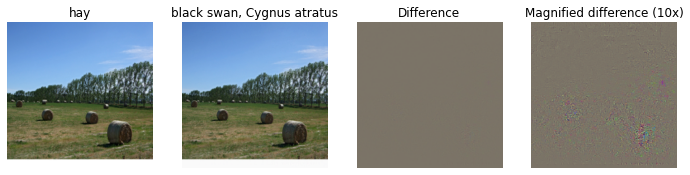

In [ ]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(idx2label[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(idx2label[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

## Class visualization

By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let I be an image and let y be a target class. Let sy(I) be the score that a convolutional network assigns to the image I for class y; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image I∗ that achieves a high score for the class y by solving the problem

$$ I∗=argmax(s_y(I)−R(I))$$
where R is a (possibly implicit) regularizer (note the sign of R(I) in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$R(I)=λ∥I∥_2^2$$
and implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the create_class_visualization function.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [ ]:
# An example of jitter


x = torch.randn(3,7)
left = x[:, :-3]
right = x[:, -3:]
display(left)
display(right)
X = torch.cat([right, left], dim=1)

display(x)
display(X)

tensor([[ 0.4327, -0.0175, -0.3887,  0.2012],
        [-1.2681, -0.5149, -2.4692, -0.4871],
        [ 1.1481, -1.1217,  0.8254,  0.0367]])

tensor([[ 0.8323, -0.1923,  0.0864],
        [-1.0000,  1.1700,  1.4699],
        [-0.4295,  1.2713, -0.8499]])

tensor([[ 0.4327, -0.0175, -0.3887,  0.2012,  0.8323, -0.1923,  0.0864],
        [-1.2681, -0.5149, -2.4692, -0.4871, -1.0000,  1.1700,  1.4699],
        [ 1.1481, -1.1217,  0.8254,  0.0367, -0.4295,  1.2713, -0.8499]])

tensor([[ 0.8323, -0.1923,  0.0864,  0.4327, -0.0175, -0.3887,  0.2012],
        [-1.0000,  1.1700,  1.4699, -1.2681, -0.5149, -2.4692, -0.4871],
        [-0.4295,  1.2713, -0.8499,  1.1481, -1.1217,  0.8254,  0.0367]])

In [ ]:
# demo: https://demonstrations.wolfram.com/ImageJitterFilter/

def jitter(X, ox, oy):    
  if ox != 0:
      left = X[:, :, :, :-ox]
      right = X[:, :, :, -ox:]
      X = torch.cat([right, left], dim=3)
  if oy != 0:
      top = X[:, :, :-oy]
      bottom = X[:, :, -oy:]
      X = torch.cat([bottom, top], dim=2)
  return X

In [ ]:
import random

def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to jitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 500)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 100)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        scores = model(img)
        score = scores[:,target_y] - (l2_reg * torch.norm(img))
        score.backward()
        img.data += (learning_rate*img.grad.data/torch.norm(img.grad.data))
        img.grad.data.zero_()
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = idx2label[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

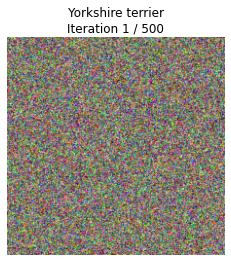

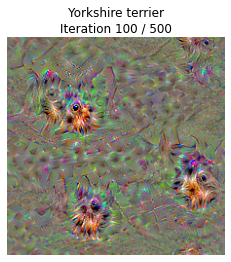

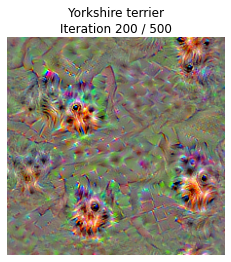

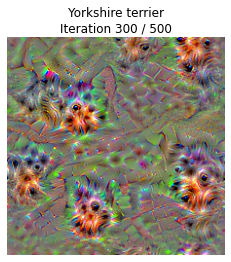

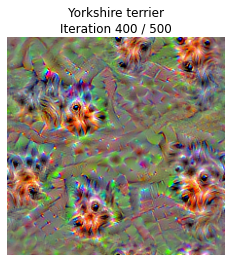

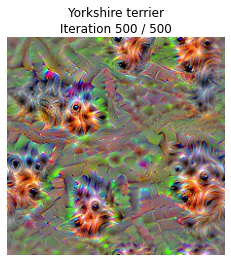

In [ ]:
dtype = torch.FloatTensor
model.type(dtype)

# target_y = 76 # Tarantula
# target_y = 78 # Tick
target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)

chiton, coat-of-mail shell, sea cradle, polyplacophore


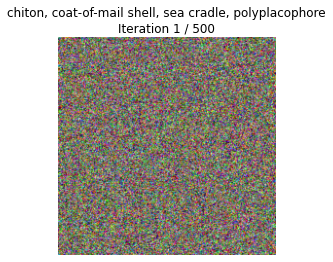

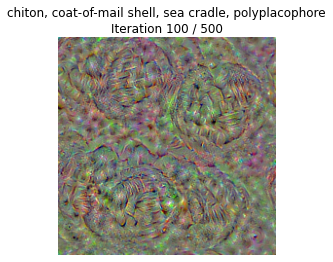

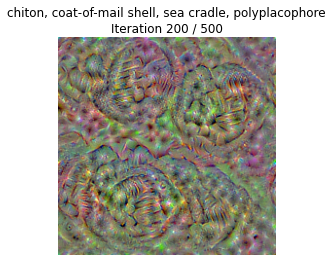

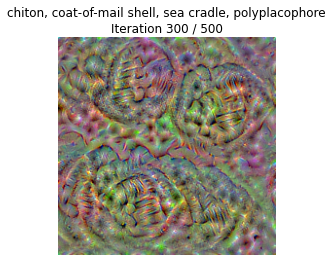

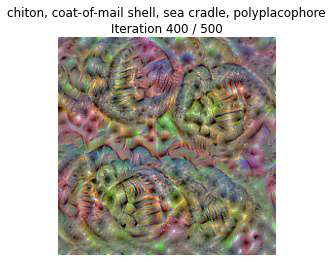

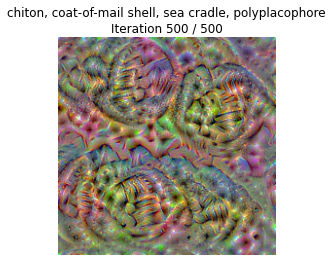

In [ ]:
target_y = np.random.randint(1000)
print(idx2label[target_y])
X = create_class_visualization(target_y, model, dtype)

# Guided Backprop

In [45]:
import torch
from torch.nn import ReLU


class GuidedBackProp():
  def __init__(self, model):
    self.model = model
    self.gradients = None
    self.forward_relu_outputs = []
    self.model.eval()
    self.update_relus()
    self.hook_layers()

  def update_relus(self):
    '''The ReLU backward pass is modified to zero-out the incoming non-negative gradients also'''
    def relu_backward_hook_function(module, grad_in, grad_out):
      current_layer_forward_output = self.forward_relu_outputs[-1]; del self.forward_relu_outputs[-1]  
      current_layer_forward_output[current_layer_forward_output > 0] = 1
      modified_grad_out = current_layer_forward_output * torch.clamp(grad_in[0], min=0.0)
      return (modified_grad_out,)

    def relu_forward_hook_function(module, ten_in, ten_out):
      self.forward_relu_outputs.append(ten_out)

    for pos, module in self.model.features._modules.items():
      if isinstance(module, ReLU):
        module.register_backward_hook(relu_backward_hook_function)
        module.register_forward_hook(relu_forward_hook_function)

  def hook_layers(self):
    '''Storing the gradients wrt the image in self.gradients for easy access later'''
    def hook_function(module, grad_in, grad_out):
        self.gradients = grad_in[0]
    first_layer = list(self.model.features._modules.items())[0][1]
    first_layer.register_backward_hook(hook_function)


  def generate_gradients(self, input_image, target_class):
    model_output = self.model(input_image)
    self.model.zero_grad()

    one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
    one_hot_output[0][target_class] = 1

    model_output.backward(gradient=one_hot_output) 

    return np.transpose(self.gradients.data.numpy()[0], (1,2,0)) 

In [57]:
from PIL import Image
from utils import *
import random

X, y, idx2label = load_imagenet_val()

model = get_pretrained_squeezenet()
X_tensor = torch.autograd.Variable(torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0), requires_grad = True)
y_tensor = torch.LongTensor(y)
idx = random.choice(range(y.shape[0]))
GBP = GuidedBackProp(model)
guided_grads = GBP.generate_gradients(X_tensor[idx:idx+1], y[idx])
guided_grads = guided_grads - guided_grads.min()
guided_grads /= guided_grads.max()
guided_grads = Image.fromarray((guided_grads*255).astype(np.uint8))
guided_grads.save('Guided_Backprop_%s.png' % (idx2label[idx]))

# File testing

## Saliency

In [9]:
!python saliency_maps.py --num_images 10 --output_dir outputs/

## Fooling

In [15]:
!python adversarial_fooling.py --num_images 10 --image_index 1 --class_index 10 --output_dir outputs/

Iteration 0, target indices' scores:  tensor([5.1447])


## Class viz.

In [27]:
!python class_visualization.py --class_index 187 --output_dir outputs/

<Figure size 400x400 with 1 Axes>
<Figure size 400x400 with 1 Axes>
<Figure size 400x400 with 1 Axes>
<Figure size 400x400 with 1 Axes>
<Figure size 400x400 with 1 Axes>
<Figure size 400x400 with 1 Axes>


In [ ]:
!python ./